# Results

### Age/Sex bias of individual genes

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from functools import reduce
import random as rand
import multiprocessing
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('./sex_bias/acuuracy_combined.csv')

# We find even 0.8 accuracy score accomodates more than 5000 genes. Therefore we raise cut-off to 0.9
df2 = df[(df.drop(['probe_id', 'Gene Symbol','ENTREZ_GENE_ID', 'Chromosome'],axis=1).abs() > 0.9).any(axis=1)]

<br>

Filter out the genes which are in X or Y chromosome.

<br>

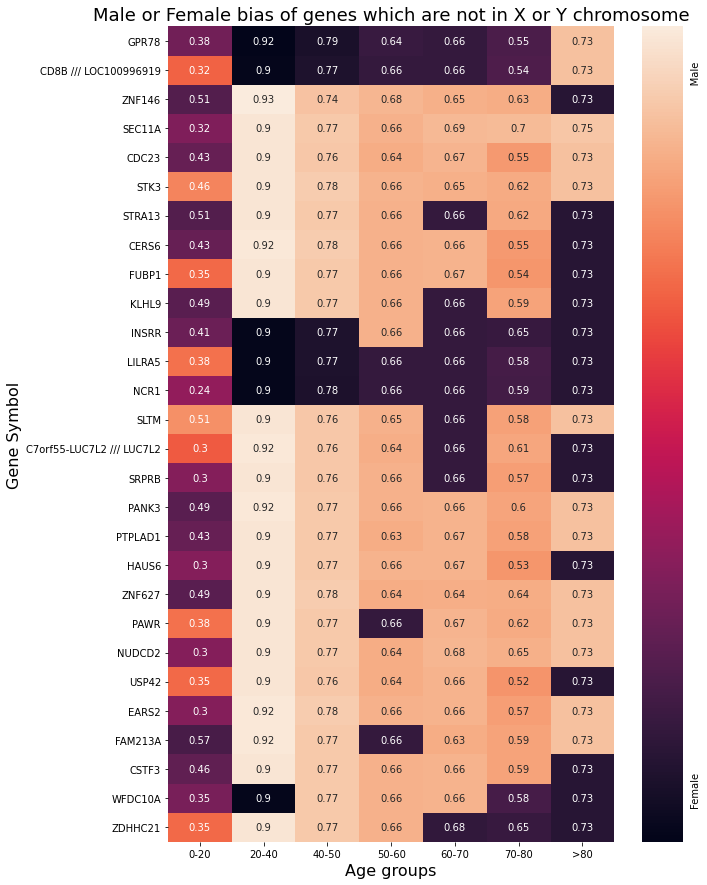

In [3]:
data = df2[~df2.Chromosome.isin(['Y','X'])].dropna().drop(['probe_id','ENTREZ_GENE_ID', 'Chromosome'],axis=1)

data.columns = ['0-20', '20-40', '40-50', '50-60',
       '60-70', '70-80', '>80', 'Gene Symbol']

data = data.set_index('Gene Symbol')
data_abs = data.abs()
fig, ax = plt.subplots(figsize=(10,15))
sns.heatmap(data, annot=data_abs, cbar_kws={'label': 'Female'+' '*220+'Male', 'ticks':[]} )
plt.xlabel('Age groups', fontsize='16')
plt.ylabel('Gene Symbol', fontsize = '16')
plt.title('Male or Female bias of genes which are not in X or Y chromosome', fontsize='18')
plt.show()

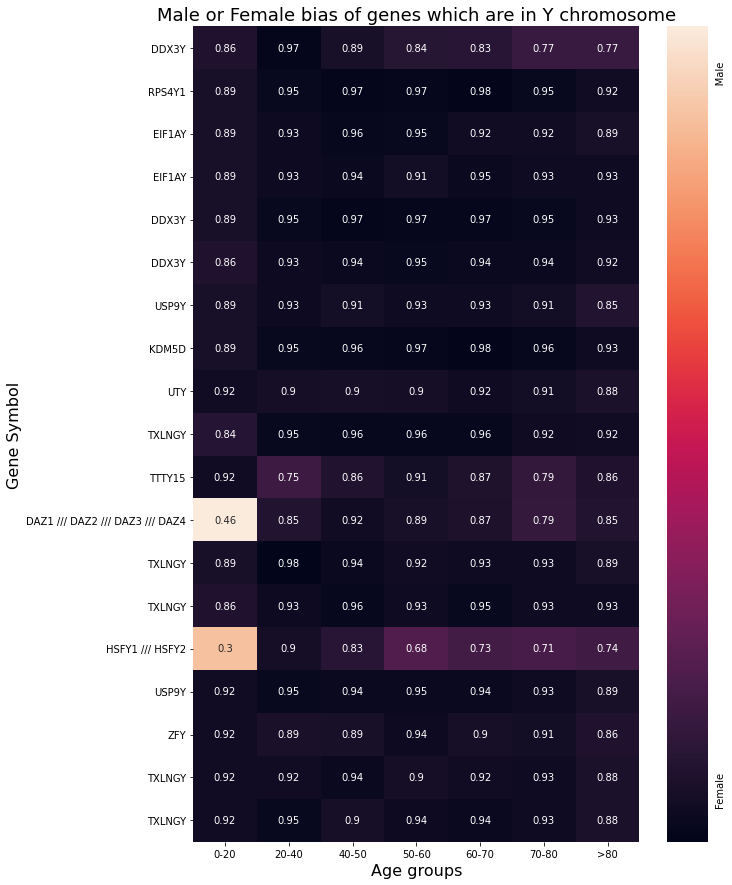

In [4]:
data2 = df2[df2.Chromosome.isin(['Y'])].dropna().drop(['probe_id','ENTREZ_GENE_ID', 'Chromosome'],axis=1)

data2.columns = ['0-20', '20-40', '40-50', '50-60',
       '60-70', '70-80', '>80', 'Gene Symbol']

data2 = data2.set_index('Gene Symbol')
data_abs = data2.abs()
fig, ax = plt.subplots(figsize=(10,15))
sns.heatmap(data2, annot=data_abs, cbar_kws={'label': 'Female'+' '*220+'Male', 'ticks':[]} )
plt.xlabel('Age groups', fontsize='16')
plt.ylabel('Gene Symbol', fontsize = '16')
plt.title('Male or Female bias of genes which are in Y chromosome', fontsize='18')
plt.show()

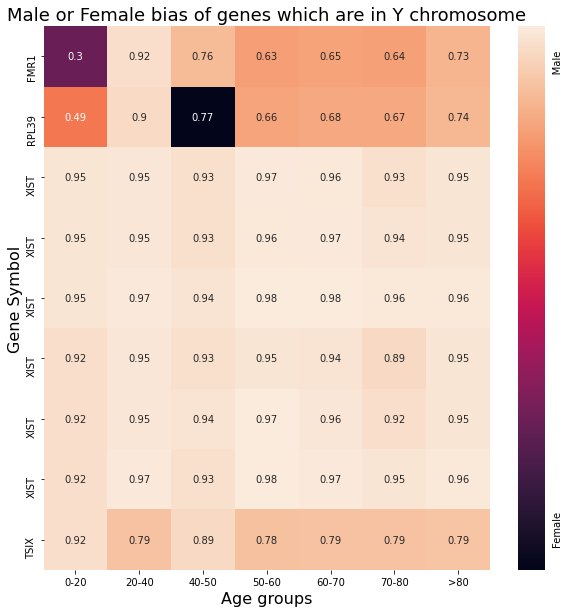

In [5]:
data2 = df2[df2.Chromosome.isin(['X'])].dropna().drop(['probe_id','ENTREZ_GENE_ID', 'Chromosome'],axis=1)

data2.columns = ['0-20', '20-40', '40-50', '50-60',
       '60-70', '70-80', '>80', 'Gene Symbol']

data2 = data2.set_index('Gene Symbol')
data_abs = data2.abs()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data2, annot=data_abs, cbar_kws={'label': 'Female'+' '*140+'Male', 'ticks':[]} )
plt.xlabel('Age groups', fontsize='16')
plt.ylabel('Gene Symbol', fontsize = '16')
plt.title('Male or Female bias of genes which are in Y chromosome', fontsize='18')
plt.show()

### Age/Sex bias of biological processes

#### Download the GO database. 
We have intentionally avaoided other databases to keep it simple. The **r-script** for downloading the GO data base is in **get_gobp_genes.r**.

We have filtered out the GO processes which has more than 15 and less than 190 genes and which has Ontology 'BP'(Biological Process). 

In [6]:
GOdb = pd.read_csv('GO_db.csv').drop('Unnamed: 0', axis=1)

important_goids = GOdb['go_id'].unique()

# Groups the GOBP ids of same number of genes

size_df = GOdb.groupby('go_id').count().reset_index().drop(['Evidence','Ontology'], axis=1).rename(columns={'gene_id':'size'})
size_list = size_df['size'].unique()

In [11]:
# Collect all accuracy score (sex bias scores) of all genes in a single data-frame

age_groups = [0,20,40,50,60,70,80,100]
accu_dfs= []
for age_ind in range(len(age_groups)-1):
    accuracy_df= pd.read_csv('./sex_bias/age_group_'+str(age_ind)+'.csv').rename(columns={'accuracy': 'age_group_'+str(age_ind)})    
    accu_dfs.append(accuracy_df)
accu_df = reduce(lambda x, y: pd.merge(x, y, on = 'probe_id'), accu_dfs)

gpl_df = pd.read_csv('GPL570-55999.txt', sep='\t', header=16, low_memory=False)
gpl_df = gpl_df.rename(columns={'ID':'probe_id'})

accu_df_comb = accu_df.merge(gpl_df[['probe_id', 'Gene Symbol', 'ENTREZ_GENE_ID']])

### Permutation (*p*) test

In [7]:
def get_dist(size,age):
    '''
    Return the mean and std of the distribution generated by 100000 random samples of same size.
    '''
    accu_df_comb['ENTREZ_GENE_ID'] = accu_df_comb['ENTREZ_GENE_ID'].apply(lambda x: str(x).split(' /// ')[0])
    gene_ids = accu_df_comb['ENTREZ_GENE_ID'].unique()
    
    itr = 0
    mean_list = []
    while itr < 1000:
        gene_set = rand.choices(gene_ids, k=size)
        mean = accu_df_comb[accu_df_comb.ENTREZ_GENE_ID.isin(gene_set)][age].mean()
        mean_list.append(mean)
        itr +=1
    stat = (np.mean(mean_list), np.std(mean_list))
    return stat

def get_process_bias(go_id, age):
    '''
    Returns the bias(in terms of accuracy) and z-score for each age group for each go_id
    '''
    accu_df_comb['ENTREZ_GENE_ID'] = accu_df_comb['ENTREZ_GENE_ID'].apply(lambda x: str(x).split(' /// ')[0])
    
    gene_ids = GOdb[GOdb['go_id'] == go_id].gene_id
    mean = accu_df_comb[accu_df_comb.ENTREZ_GENE_ID.isin(gene_ids.map(str))][age].mean()
    sz = len(gene_ids)
    z_score = (mean - eval(list(stat_df[stat_df['size'] == sz][age])[0])[0])/ eval(list(stat_df[stat_df['size'] == sz][age])[0])[1]
    return mean, z_score

In [13]:
%%time

stat_df = pd.DataFrame({'size':size_list})
for i in range(7):
    age_idx = 'age_group_'+str(i)
    #num_processes = multiprocessing.cpu_count()
    pool = multiprocessing.Pool(12) ### number of processesor I want to use
    def get_dist_age(x):
        return get_dist(x,age_idx)
    stat_list = pool.map(get_dist_age, list(size_list))
    stat_df[age_idx] = stat_list    

CPU times: user 389 ms, sys: 510 ms, total: 899 ms
Wall time: 8min 22s


In [16]:
stat_df.to_csv('stats.csv') # Save the result to avoid running same code multiple time
stat_df = pd.read_csv('stats.csv')

In [17]:
# Calculation of Z-score for each process in each age-group

%time
enrich_df = pd.DataFrame({'go_id': important_goids})
bias_df = pd.DataFrame({'go_id': important_goids})
for i in range(7):
    age_idx = 'age_group_'+str(i)
    bias_list = []
    z_score_list = []
    for go_id in important_goids: 
        bias, z_score = get_process_bias(go_id, age_idx)
        bias_list.append(bias)
        z_score_list.append(z_score)
    enrich_df[age_idx] = z_score_list
    bias_df[age_idx] = bias_list

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 2.86 µs


In [18]:
# Save results
enrich_df.to_csv('enrichment_scores.csv')
bias_df.to_csv('process_biases.csv')

<br>

Seperate out the processes which are male biased or female biased. Then within those groups find out bias of which processes increase with increasing age and bias of which processes decrease with increase age.

To do so, we fit the bias scores of different age groups in linear regression model. We consider only those GOBP which shows mean squred error less than 0.01. For other GOBP, we conclude that there is no clear evidence of age trend. 

<br>

In [19]:
def get_age_trend(go_id):
    lin = LinearRegression()
    X= np.arange(1,8).reshape(-1,1)
    y = bias_df[bias_df['go_id'] == idd].iloc[0,:][1:]
    lin.fit(X,y)
    mse = mean_squared_error(lin.predict(X),y)
    if mse < 0.01 and lin.coef_[0] > 0:
        return 'I'
    elif mse < 0.01 and lin.coef_[0] < 0:
        return 'D'
    elif mse > 0.01:
        return np.nan

In [20]:
age_trend_df = pd.DataFrame({'go_id':important_goids})
sex_bias_list = []
age_trend_list = []
for idd in important_goids:
    if (bias_df[bias_df['go_id'] == idd].iloc[0,:][1:] < 0 ).values.all():
        sex_bias_list.append('Male')
    elif (bias_df[bias_df['go_id'] == idd].iloc[0,:][1:] > 0 ).values.all():
        sex_bias_list.append('Female')
    else:
        sex_bias_list.append(np.nan)
    
    age_trend_list.append(get_age_trend(idd))

age_trend_df['sex_bias'] = sex_bias_list
age_trend_df['age_trend'] = age_trend_list

In [22]:
male_increasing_ids = age_trend_df[(age_trend_df.sex_bias == 'Male') & (age_trend_df.age_trend == 'I')].go_id
male_decreasing_ids = age_trend_df[(age_trend_df.sex_bias == 'Male') & (age_trend_df.age_trend == 'D')].go_id
female_increasing_ids = age_trend_df[(age_trend_df.sex_bias == 'Female') & (age_trend_df.age_trend == 'I')].go_id
female_decreasing_ids = age_trend_df[(age_trend_df.sex_bias == 'Female') & (age_trend_df.age_trend == 'D')].go_id

In [31]:
def get_plot(go_id_list):
    term_df = GOdb[GOdb.go_id.isin(go_id_list)][['go_id','terms']].drop_duplicates()
    enrich_df.columns = ['go_id','0-20', '20-40', '40-50', '50-60',
       '60-70', '70-80', '>80']
    dff = enrich_df[enrich_df.go_id.isin(go_id_list)]
    new_df = dff.merge(term_df).drop('go_id',axis =1)
    terms = new_df.pop('terms')
    new_df.insert(0,'terms', terms)
    new_df.set_index('terms', inplace=True)
    fig, ax = plt.subplots(figsize=(5,8))
    pallete = sns.color_palette("Blues", 8)
    return sns.heatmap(new_df, cmap=pallete, vmin=-5, vmax=5, cbar_kws={'label': 'Z-score'})

Text(23.99999999999998, 0.5, '')

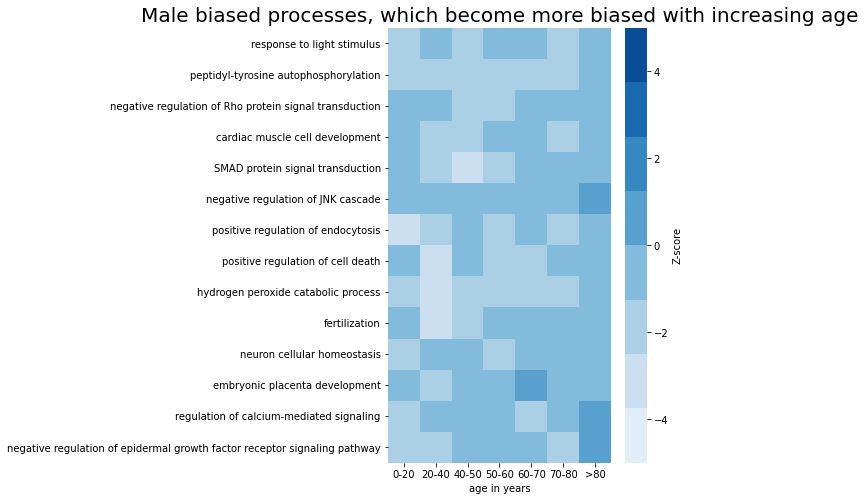

In [32]:
get_plot(male_increasing_ids[:20])
plt.title('Male biased processes, which become more biased with increasing age', fontsize=20)
plt.xlabel('age in years')
plt.ylabel('')

Text(23.999999999999975, 0.5, '')

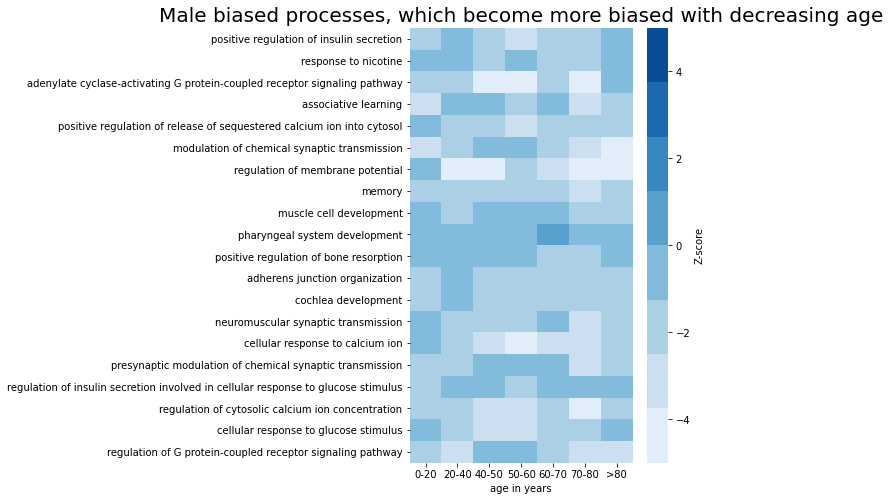

In [33]:
get_plot(male_decreasing_ids[:20])
plt.title('Male biased processes, which become more biased with decreasing age', fontsize=20)
plt.xlabel('age in years')
plt.ylabel('')

Text(23.99999999999998, 0.5, '')

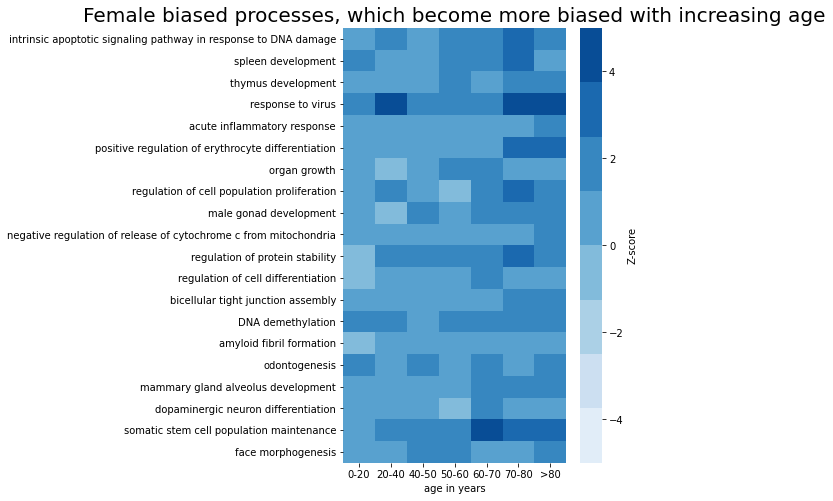

In [34]:
get_plot(female_increasing_ids[:20])
plt.title('Female biased processes, which become more biased with increasing age', fontsize=20)
plt.xlabel('age in years')
plt.ylabel('')

Text(23.999999999999986, 0.5, '')

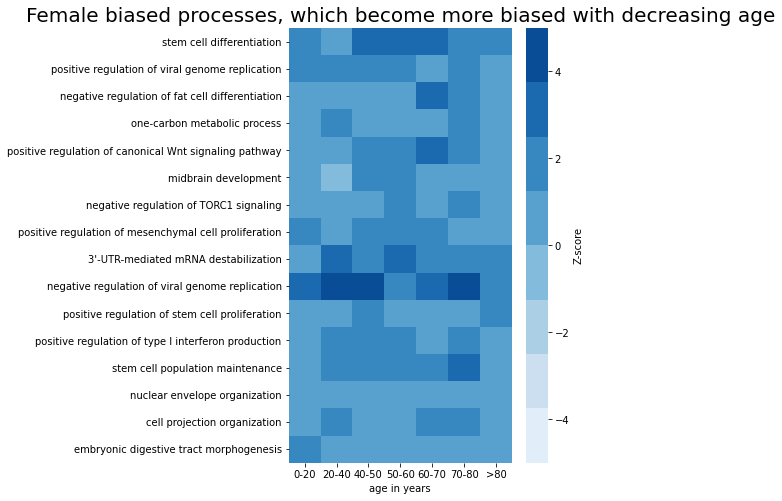

In [35]:
get_plot(female_decreasing_ids[:20])
plt.title('Female biased processes, which become more biased with decreasing age', fontsize=20)
plt.xlabel('age in years')
plt.ylabel('')

### Thoughts

This above process of finding sex-bias by averaging the bias score of each individual gene might not be correct, since the expression of the genes in a sample is expected to be highly correlated with other genes.

I was trying a different way to find the sex-bias of GOBP's. 

- Use GOStat's Hypergeometric test to find the GOBP which is mostly enriched compared to others.
- Do that for all samples
- For each GOBP in each age group find 
${\rm Number\ of\ Male\ Samples}\over {\rm Number\ of\ Female\ samples}$

Unfortunately, I do not have so many samples for each GOBP to do this. 